In [13]:
import numpy as np
import math
from numba import jit
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import time

Simulate data set

In [148]:
#construct simulation data set in the paper

#set seed
np.random.seed(1)
s=50

#construct u
u_tilde = np.concatenate((np.array([10,9,8,7,6,5,4,3]),np.repeat(2,17),
                          np.repeat(0,75)), axis=0)
u = u_tilde/np.linalg.norm(u_tilde)#normalize
u=u.reshape(len(u),1)#u is 100 x 1

#construct v
v_tilde=np.concatenate((np.array([10,-10,8,-8,5,-5]),np.repeat(3,5),
                        np.repeat(-3,5),np.repeat(0,34)),axis=0)
v = v_tilde/np.linalg.norm(v_tilde)#normalize
v=v.reshape(1,len(v))#v is 1 x 50

#construct noise matrix epsilon
epsilon=np.random.normal(0,1,100*50).reshape(100,50) #100 x 50

#construct X=X^*+epsilon==suv^T+epsilon
X = s*u@v + epsilon

Thresh function

In [3]:
def thresh(z,delta):
    return np.sign(z)*(np.abs(z) >= delta)*(np.abs(z)-delta)

Unoptimized ssvd function

In [4]:
def ssvd(X, gamma_u = 2, gamma_v = 2, merr = 10**(-4), niter = 100):
    #rank 1
    U,s,V = np.linalg.svd(X)#initial svd
    u0 = U.T[0] 
    v0 = V.T[0]

    n=X.shape[0]
    d=X.shape[1]
    ud = 1
    vd = 1
    iters = 0
    SST = np.sum(X*X)

    while (ud > merr or vd > merr):
        iters = iters + 1

        #update v
        z=X.T @ u0#initial OLS estimator (of the coefficients)
        w_v_inv=np.abs(z) ** gamma_v#inverse of adapative weight 
        sig_sq=np.abs(SST-np.sum(z*z))/(n*d-d)#OLS estimate of the error variance
        tmp=z*w_v_inv
        tv=np.unique(np.sort(np.append(np.abs(tmp),0)))#possible lambda set
        Bv = np.ones(len(tv)-1)*np.Inf
        index=np.where(w_v_inv>10^-8)
        tmp1=tmp[index]
        w_v_inv1=w_v_inv[index]
        for i in range(len(Bv)):
            temp2 = thresh(tmp1,delta = tv[i])
            temp2 = temp2/w_v_inv1
            temp3 = np.zeros(d)
            temp3[index] = temp2
            Bv[i] = np.sum((X - u0[:,None] @ temp3[None,:])**2)/sig_sq + np.sum(temp2!=0)*math.log(n*d)
        Iv = min(np.where(Bv== np.min(Bv)))
        th = tv[Iv]
        temp2 = thresh(tmp1,delta = th)
        temp2 = temp2/w_v_inv1
        v1 = np.zeros(d)
        v1[index] = temp2
        v1 = v1/((np.sum(v1*v1))**0.5) #v_new

        #update v
        z=X @ v1#initial OLS estimator (of the coefficients)
        w_u_inv=np.abs(z) ** gamma_u#inverse of adapative weight 
        sig_sq=np.abs(SST-np.sum(z*z))/(n*d-n)#OLS estimate of the error variance
        tmp=z*w_u_inv
        tv=np.unique(np.sort(np.append(np.abs(tmp),0)))#possible lambda set
        Bu = np.ones(len(tv)-1)*np.Inf
        index=np.where(w_u_inv>10^-8)
        tmp1=tmp[index]
        w_u_inv1=w_u_inv[index]
        for i in range(len(Bu)):
            temp2 = thresh(tmp1,delta = tv[i])
            temp2 = temp2/w_u_inv1
            temp3 = np.zeros(n)
            temp3[index] = temp2
            Bu[i] =  np.sum((X - temp3[:,None] @ v1[None,:])**2)/sig_sq + np.sum(temp2!=0)*math.log(n*d)
        Iu = min(np.where(Bu== np.min(Bu)))
        th = tv[Iu]
        temp2 = thresh(tmp1,delta = th)
        temp2 = temp2/w_u_inv1
        u1 = np.zeros(n)
        u1[index] = temp2
        u1 = u1/((np.sum(u1*u1))**0.5) #u_new

        ud = np.sum((u0-u1)*(u0-u1))**0.5
        vd = np.sum((v0-v1)*(v0-v1))**0.5

        if iters > niter :
            print("Fail to converge! Increase the niter!")
            break

        u0 = u1
        v0 = v1

    s = u1[None, :] @ X @ v1[:, None]
    return u1, v1, s, iters

In [5]:
%prun ssvd(X)

JIT decorator for optimization

In [5]:
@jit
def thresh_jit(z,delta):
    return np.sign(z)*(np.abs(z) >= delta)*(np.abs(z)-delta)

In [6]:
def ssvd_jit(X, gamma_u = 2, gamma_v = 2, merr = 10**(-4), niter = 100):
    #rank 1
    U,s,V = np.linalg.svd(X)#initial svd
    u0 = U.T[0] 
    v0 = V.T[0]

    n=X.shape[0]
    d=X.shape[1]
    ud = 1
    vd = 1
    iters = 0
    SST = np.sum(X*X)

    while (ud > merr or vd > merr):
        iters = iters + 1

        #update v
        z=X.T @ u0#initial OLS estimator (of the coefficients)
        w_v_inv=np.abs(z) ** gamma_v#inverse of adapative weight 
        sig_sq=np.abs(SST-np.sum(z*z))/(n*d-d)#OLS estimate of the error variance
        tmp=z*w_v_inv
        tv=np.unique(np.sort(np.append(np.abs(tmp),0)))#possible lambda set
        Bv = np.ones(len(tv)-1)*np.Inf
        index=np.where(w_v_inv>10^-8)
        tmp1=tmp[index]
        w_v_inv1=w_v_inv[index]
        for i in range(len(Bv)):
            temp2 = thresh_jit(tmp1,delta = tv[i])
            temp2 = temp2/w_v_inv1
            temp3 = np.zeros(d)
            temp3[index] = temp2
            Bv[i] = np.sum((X - u0[:,None] @ temp3[None,:])**2)/sig_sq + np.sum(temp2!=0)*math.log(n*d)
        Iv = min(np.where(Bv== np.min(Bv)))
        th = tv[Iv]
        temp2 = thresh_jit(tmp1,delta = th)
        temp2 = temp2/w_v_inv1
        v1 = np.zeros(d)
        v1[index] = temp2
        v1 = v1/((np.sum(v1*v1))**0.5) #v_new

        #update v
        z=X @ v1#initial OLS estimator (of the coefficients)
        w_u_inv=np.abs(z) ** gamma_u#inverse of adapative weight 
        sig_sq=np.abs(SST-np.sum(z*z))/(n*d-n)#OLS estimate of the error variance
        tmp=z*w_u_inv
        tv=np.unique(np.sort(np.append(np.abs(tmp),0)))#possible lambda set
        Bu = np.ones(len(tv)-1)*np.Inf
        index=np.where(w_u_inv>10^-8)
        tmp1=tmp[index]
        w_u_inv1=w_u_inv[index]
        for i in range(len(Bu)):
            temp2 = thresh_jit(tmp1,delta = tv[i])
            temp2 = temp2/w_u_inv1
            temp3 = np.zeros(n)
            temp3[index] = temp2
            Bu[i] =  np.sum((X - temp3[:,None] @ v1[None,:])**2)/sig_sq + np.sum(temp2!=0)*math.log(n*d)
        Iu = min(np.where(Bu== np.min(Bu)))
        th = tv[Iu]
        temp2 = thresh_jit(tmp1,delta = th)
        temp2 = temp2/w_u_inv1
        u1 = np.zeros(n)
        u1[index] = temp2
        u1 = u1/((np.sum(u1*u1))**0.5) #u_new

        ud = np.sum((u0-u1)*(u0-u1))**0.5
        vd = np.sum((v0-v1)*(v0-v1))**0.5

        if iters > niter :
            print("Fail to converge! Increase the niter!")
            break

        u0 = u1
        v0 = v1

    s = u1[None, :] @ X @ v1[:, None]
    return u1, v1, s, iters

In [50]:
from ipyparallel import Client
rc = Client()
dv = rc[:]

@dv.parallel(block=True)

def thresh(z,delta):
    return np.sign(z)*(np.abs(z) >= delta)*(np.abs(z)-delta)

def ssvd(X, gamma_u = 2, gamma_v = 2, merr = 10**(-4), niter = 100):
    #rank 1
    U,s,V = np.linalg.svd(X)#initial svd
    u0 = U.T[0] 
    v0 = V.T[0]

    n=X.shape[0]
    d=X.shape[1]
    ud = 1
    vd = 1
    iters = 0
    SST = np.sum(X*X)

    while (ud > merr or vd > merr):
        iters = iters + 1

        #update v
        z=X.T @ u0#initial OLS estimator (of the coefficients)
        w_v_inv=np.abs(z) ** gamma_v#inverse of adapative weight 
        sig_sq=np.abs(SST-np.sum(z*z))/(n*d-d)#OLS estimate of the error variance
        tmp=z*w_v_inv
        tv=np.unique(np.sort(np.append(np.abs(tmp),0)))#possible lambda set
        Bv = np.ones(len(tv)-1)*np.Inf
        index=np.where(w_v_inv>10^-8)
        tmp1=tmp[index]
        w_v_inv1=w_v_inv[index]
        for i in range(len(Bv)):
            temp2 = thresh(tmp1,delta = tv[i])
            temp2 = temp2/w_v_inv1
            temp3 = np.zeros(d)
            temp3[index] = temp2
            Bv[i] = np.sum((X - u0[:,None] @ temp3[None,:])**2)/sig_sq + np.sum(temp2!=0)*math.log(n*d)
        Iv = min(np.where(Bv== np.min(Bv)))
        th = tv[Iv]
        temp2 = thresh(tmp1,delta = th)
        temp2 = temp2/w_v_inv1
        v1 = np.zeros(d)
        v1[index] = temp2
        v1 = v1/((np.sum(v1*v1))**0.5) #v_new

        #update v
        z=X @ v1#initial OLS estimator (of the coefficients)
        w_u_inv=np.abs(z) ** gamma_u#inverse of adapative weight 
        sig_sq=np.abs(SST-np.sum(z*z))/(n*d-n)#OLS estimate of the error variance
        tmp=z*w_u_inv
        tv=np.unique(np.sort(np.append(np.abs(tmp),0)))#possible lambda set
        Bu = np.ones(len(tv)-1)*np.Inf
        index=np.where(w_u_inv>10^-8)
        tmp1=tmp[index]
        w_u_inv1=w_u_inv[index]
        for i in range(len(Bu)):
            temp2 = thresh(tmp1,delta = tv[i])
            temp2 = temp2/w_u_inv1
            temp3 = np.zeros(n)
            temp3[index] = temp2
            Bu[i] =  np.sum((X - temp3[:,None] @ v1[None,:])**2)/sig_sq + np.sum(temp2!=0)*math.log(n*d)
        Iu = min(np.where(Bu== np.min(Bu)))
        th = tv[Iu]
        temp2 = thresh(tmp1,delta = th)
        temp2 = temp2/w_u_inv1
        u1 = np.zeros(n)
        u1[index] = temp2
        u1 = u1/((np.sum(u1*u1))**0.5) #u_new

        ud = np.sum((u0-u1)*(u0-u1))**0.5
        vd = np.sum((v0-v1)*(v0-v1))**0.5

        if iters > niter :
            print("Fail to converge! Increase the niter!")
            break

        u0 = u1
        v0 = v1

    s = u1[None, :] @ X @ v1[:, None]
    return u1, v1, s, iters

In [48]:
%%timeit
from concurrent.futures import ThreadPoolExecutor

with ThreadPoolExecutor(max_workers=4) as pool:
    res = pool.map(lambda x: ssvd(x), X)

4.43 ms ± 46.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [7]:
%timeit ssvd(X)

43.8 ms ± 1.34 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [8]:
%timeit ssvd_jit(X)

39.1 ms ± 1.61 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [51]:
%timeit dv.map(lambda x: ssvd(x), X)

5.15 ms ± 296 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Compare output of ssvd functions to ensure results are correct.

In [10]:
np.testing.assert_array_almost_equal((ssvd_jit(X))[0], (ssvd(X))[0])

Application to simulated data sets

In [13]:
#1st layer on simulated data
res1 = ssvd_jit(X)
X_star_1=res1[2]*res1[0][:,None]*res1[1][None,:]

#2nd layer
res2=ssvd_jit(X-X_star_1)
X_star_2=res2[2]*res2[0][:,None]*res2[1][None,:]

#3rd layer
res3=ssvd_jit(X-X_star_1-X_star_2,merr=10**(-2))
X_star_3=res3[2]*res3[0][:,None]*res3[1][None,:]

In [14]:
# all entries of the layers are first divided by 
# the maximum absolute value of the entries from all three layers
Max=np.max(np.array([np.max(np.abs(X_star_1)),np.max(np.abs(X_star_2)),np.max(np.abs(X_star_3))]))
X_star_1_scaled=X_star_1/Max
X_star_2_scaled=X_star_2/Max
X_star_3_scaled=X_star_3/Max

#sort the coloumn of each layer based on an ascending ordering of v
X_star_1_sorted=X_star_1_scaled[:,np.argsort(res1[1])]
X_star_2_sorted=X_star_2_scaled[:,np.argsort(res2[1])]
X_star_3_sorted=X_star_3_scaled[:,np.argsort(res3[1])]

Text(0.5,1,'1st Layer')

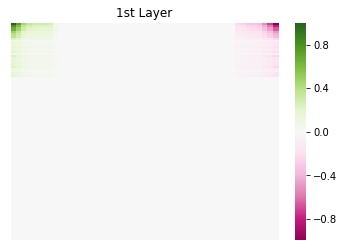

In [25]:
img1 = sns.heatmap(X_star_1_sorted,xticklabels=False, yticklabels=False,center=0,cmap="PiYG")
plt.title("1st Layer")

Application to real data sets

In [113]:
#first we try to apply the SSVD to the lung cancer data set in the paper
#and try to reproduce the image generated in the paper.
#import data set
data = np.loadtxt("data.txt", dtype = "float", delimiter = " ")
X=data.T

In [9]:
#perform ssvd on X and the residuals to extract the first three layers
#save the extracted layers for convience

#1st ssvd
res1=ssvd_jit(X)
#1st layer: X*=s_1*u_1(n x 1)*v_1(1 x d)
X_star_1=res1[2]*res1[0][:,None]*res1[1][None,:]
np.savetxt('l1',X_star_1)

#2nd ssvd
res2=ssvd_jit(X-l1)
#2nd layer: X*=s_2*u_2(n x 1)*v_2(1 x d)
X_star_2=res2[2]*res2[0][:,None]*res2[1][None,:]
np.savetxt('l2',X_star_2)

#3rd ssvd
res3=ssvd_jit(X-l1-l2,merr=10**(-2))
#3rd layer: X*=s_3*u_3(n x 1)*v_3(1 x d)
X_star_3=res3[2]*res3[0][:,None]*res3[1][None,:]
np.savetxt('l3',X_star_3)

In [48]:
#load the saved layers
l1 = np.loadtxt("l1", dtype = "float", delimiter = " ")
l2 = np.loadtxt("l2", dtype = "float", delimiter = " ")
l3 = np.loadtxt("l3", dtype = "float", delimiter = " ")

# all entries of the layers are first divided by 
# the maximum absolute value of the entries from all three layers
Max=np.max(np.array([np.max(np.abs(l1)),np.max(np.abs(l2)),np.max(np.abs(l3))]))
l1_scaled=l1/Max
l2_scaled=l2/Max
l3_scaled=l3/Max

#sort the coloumn of each layer based on an ascending ordering of v
l1_sorted=l1_scaled[:,np.argsort(res1[1])]
l2_sorted=l2_scaled[:,np.argsort(res2[1])]
l3_sorted=l3_scaled[:,np.argsort(res3[1])]


In [74]:
#the information of the types of cancer is not used in the algorithm 
#but is used for interpretation of the checkboard patterns of the generated matrix approximation.
#from the readme file, we know that among the 56 cases: the rows are arranged as following:Carcinoid:1-20;
#Colon:21:33; Normal:34-50; SmallCell:51-56

#then we want to rearrange the rows for each cancer type in each layer based on u
index_row_1=np.concatenate((np.argsort(res1[0][:20]),np.argsort(res1[0][21:34])+20
                            ,np.argsort(res1[0][34:51])+33,np.argsort(res1[0][51:])+51),axis=0)

index_row_2=np.concatenate((np.argsort(res2[0][:20]),np.argsort(res2[0][21:34])+20
                            ,np.argsort(res2[0][34:51])+33,np.argsort(res2[0][51:])+51),axis=0)

index_row_3=np.concatenate((np.argsort(res3[0][:20]),np.argsort(res3[0][21:34])+20
                            ,np.argsort(res3[0][34:51])+33,np.argsort(res3[0][51:])+51),axis=0)

l1_plot=l1_sorted[index_row_1,:]
l2_plot=l2_sorted[index_row_2,:]
l3_plot=l3_sorted[index_row_3,:]

#also, 8000 genes in the middle white area are excluded, otherwise the plot woudl be too long
l1_deleted=np.delete(l1_plot,np.arange(1463,1463+8000,1),1)
l2_deleted=np.delete(l2_plot,np.arange(1489,1489+8000,1),1)
l3_deleted=np.delete(l3_plot,np.arange(695,695+8000,1),1)

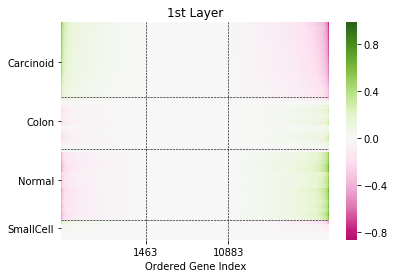

In [94]:
img1 = sns.heatmap(l1_deleted,xticklabels=False, yticklabels=False,center=0,cmap="PiYG")
img1.set(xlabel = "Ordered Gene Index", ylabel = "") 
plt.plot(list(image1.get_xlim()), [50,50], 'k--', linewidth = 0.6)
plt.plot(list(image1.get_xlim()), [32,32], 'k--', linewidth = 0.6)
plt.plot(list(image1.get_xlim()), [19,19], 'k--', linewidth = 0.6)
plt.plot([1462, 1462], list(image1.get_ylim()), 'k--', linewidth = 0.6)
plt.plot([10882-8000, 10882-8000], list(image1.get_ylim()), 'k--', linewidth = 0.6)
plt.yticks([52,40,25,10], ["SmallCell", "Normal", "Colon", "Carcinoid"])
plt.xticks([1462, 10882-8000], ["1463", "10883"])
plt.title("1st Layer")
pass
plt.savefig('l1.jpg')

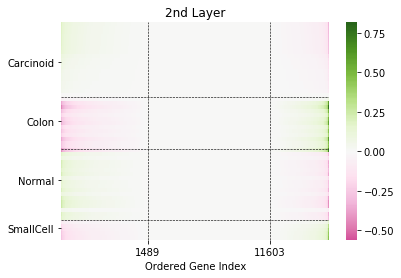

In [96]:
img2 = sns.heatmap(l2_deleted,xticklabels=False, yticklabels=False,center=0,cmap="PiYG")
img2.set(xlabel = "Ordered Gene Index", ylabel = "") 
plt.plot(list(image2.get_xlim()), [50,50], 'k--', linewidth = 0.6)
plt.plot(list(image2.get_xlim()), [32,32], 'k--', linewidth = 0.6)
plt.plot(list(image2.get_xlim()), [19,19], 'k--', linewidth = 0.6)
plt.plot([1489, 1489], list(image2.get_ylim()), 'k--', linewidth = 0.6)
plt.plot([11603-8000, 11603-8000], list(image2.get_ylim()), 'k--', linewidth = 0.6)
plt.yticks([52,40,25,10], ["SmallCell", "Normal", "Colon", "Carcinoid"])
plt.xticks([1489, 11603-8000], ["1489", "11603"])
plt.title("2nd Layer")
pass
plt.savefig('l2.jpg')

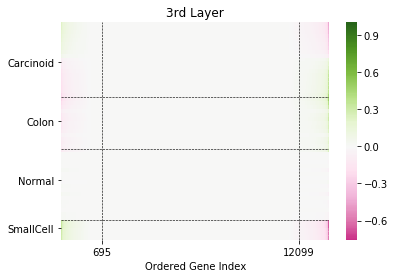

In [97]:
img3 = sns.heatmap(l3_deleted,xticklabels=False, yticklabels=False,center=0,cmap="PiYG")
img3.set(xlabel = "Ordered Gene Index", ylabel = "") 
plt.plot(list(image3.get_xlim()), [50,50], 'k--', linewidth = 0.6)
plt.plot(list(image3.get_xlim()), [32,32], 'k--', linewidth = 0.6)
plt.plot(list(image3.get_xlim()), [19,19], 'k--', linewidth = 0.6)
plt.plot([695, 695], list(image3.get_ylim()), 'k--', linewidth = 0.6)
plt.plot([12099-8000, 12099-8000], list(image3.get_ylim()), 'k--', linewidth = 0.6)
plt.yticks([52,40,25,10], ["SmallCell", "Normal", "Colon", "Carcinoid"])
plt.xticks([695, 12099-8000], ["695", "12099"])
plt.title("3rd Layer")
pass
plt.savefig('l3.jpg')

In [114]:
X

array([[ 0.16395136, -0.68940011,  0.0903335 , ..., -0.05674101,
        -0.3349708 ,  0.00861044],
       [-0.08380222, -0.19013764, -0.22497703, ..., -0.08102412,
        -0.37745715,  0.01948322],
       [-0.14113676,  0.16980615, -0.24375927, ..., -0.19249953,
        -0.60116433, -0.14442642],
       ...,
       [-0.0272442 ,  0.7945277 ,  0.36516356, ..., -0.64742524,
        -1.08217908, -0.78665237],
       [-0.32148505, -0.2840104 ,  0.27456986, ...,  0.01364799,
        -0.27535703, -0.13843673],
       [-0.20785902, -0.59103832, -0.0277307 , ...,  0.24725894,
        -0.62006452, -0.09548951]])

In [7]:
#MNIST data set
#load data set
mnist = np.loadtxt("mnist.txt", dtype = "float", delimiter = " ")
X=mnist.T

In [8]:
X.shape

(50, 439)

In [21]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [24]:
#1st ssvd
res1=ssvd(X)
#1st layer: X*=s_1*u_1(n x 1)*v_1(1 x d)
X_star_1=res1[2]*res1[0][:,None]*res1[1][None,:]

# all entries of the layers are first divided by 
# the maximum absolute value of the entries from all three layers
Max=np.max(np.abs(X_star_1))
X_star_1_scaled=X_star_1/Max

#sort the coloumn of each layer based on an ascending ordering of v
X_star_1_sorted=X_star_1_scaled[:,np.argsort(res1[1])]

Text(0.5,1,'1st Layer')

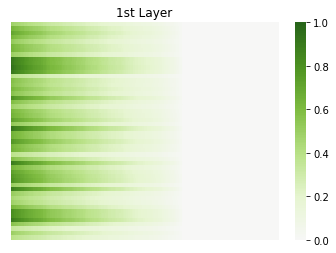

In [25]:
img1 = sns.heatmap(X_star_1_sorted,xticklabels=False, yticklabels=False,center=0,cmap="PiYG")
plt.title("1st Layer")

In [26]:
from sklearn.cluster.bicluster import SpectralBiclustering

In [32]:
model = SpectralBiclustering()

In [152]:
model.fit(X)

SpectralBiclustering(init='k-means++', method='bistochastic',
           mini_batch=False, n_best=3, n_clusters=3, n_components=6,
           n_init=10, n_jobs=1, n_svd_vecs=None, random_state=None,
           svd_method='randomized')

In [151]:
X

array([[ 12.54397908, -11.53139013,   8.20753522, ...,   2.10025514,
          0.12015895,   0.61720311],
       [ 10.12784066, -10.17992019,   6.71961808, ...,   0.04359686,
         -0.62000084,   0.69803203],
       [  8.28857841,  -7.51119927,   7.39205722, ...,   0.61838026,
          0.23249456,   0.68255141],
       ...,
       [  0.60063444,   1.5345797 ,   0.05044703, ...,  -0.40694634,
         -0.36914814,   0.18065712],
       [  0.13507455,   0.96862199,  -0.09431686, ...,  -0.96284878,
         -1.5679603 ,  -0.15194739],
       [ -0.43238091,  -0.03576256,   1.51281994, ...,  -0.77598779,
          1.08488869,   2.24198946]])

In [153]:
fit_data = X[np.argsort(model.row_labels_)]
fit_data = fit_data[:, np.argsort(model.column_labels_)]

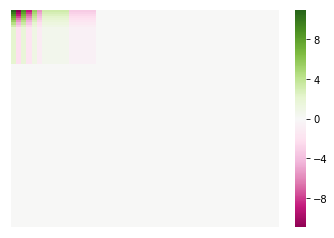

In [154]:
sns.heatmap(X_star,xticklabels=False, yticklabels=False,center=0,cmap="PiYG")

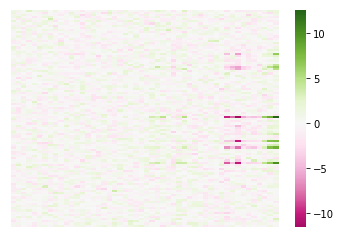

In [155]:
sns.heatmap(fit_data,xticklabels=False, yticklabels=False,center=0,cmap="PiYG")